## Data Loading 

Necessary Imports

In [1]:
import os
import wfdb
import pandas as pd
import numpy as np
import matplotlib as plt
import ast
import time
from pathlib import Path


from hrvanalysis import get_time_domain_features
from hrvanalysis import get_frequency_domain_features
import pywt
import EntropyHub as EH
import scipy

Read file names from the directory containg the data-set and retain the file name without the ".dat" and ".hea" ending

In [2]:
dir_name = 'C:/Users/Nefeli/Desktop/biomed_project_data/'  
directory = Path(dir_name) #path obj creation
file_names = [file.name for file in directory.iterdir() if file.is_file()] #list all files
#keep .dat files and strip ending to retain number form only
file_id=[]
for file in file_names:
    if file.endswith(".hea"): 
        file_id.append(file.rstrip(".hea"))

Test for record retrieval

In [3]:
testOn = 0 
#test record retrieval
if testOn == 1 :
    record = wfdb.rdrecord('C:/Users/Nefeli/Desktop/biomed_project_data/'+file_id[0]) 
    print(record.__dict__)

Create a dataframe to hold all data

In [4]:
attributes=[]
record = wfdb.rdrecord('C:/Users/Nefeli/Desktop/biomed_project_data/'+file_id[0]) 
for attribute, value in record.__dict__.items():
    attributes.append(attribute)
    
allDataDf = pd.DataFrame(columns=attributes)

print(allDataDf.info)

<bound method DataFrame.info of Empty DataFrame
Columns: [record_name, n_sig, fs, counter_freq, base_counter, sig_len, base_time, base_date, comments, sig_name, p_signal, d_signal, e_p_signal, e_d_signal, file_name, fmt, samps_per_frame, skew, byte_offset, adc_gain, baseline, units, adc_res, adc_zero, init_value, checksum, block_size]
Index: []

[0 rows x 27 columns]>


Iterate over file names and retain the corresponding value on the respective attribute column

In [5]:
#first check if attributes are the same for all data entries
scores=[0]*len(attributes)
for i in range(len(file_id)):
    record = wfdb.rdrecord('C:/Users/Nefeli/Desktop/biomed_project_data/'+file_id[i])
    for j in range(len(attributes)):
        for attribute, value in record.__dict__.items():
            if attribute == attributes[j]:
                scores[j] = scores[j]+1
        #print(type(value))
        #allDataDf.loc[i,attribute] = value
        
print(scores)

[552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552]


In [6]:
#then check if values corresponding to each attribute are of the same type for all data entries
types=[]
for i in range(len(file_id)):
    record = wfdb.rdrecord('C:/Users/Nefeli/Desktop/biomed_project_data/'+file_id[i])
    for j in range(len(attributes)):
        typeList=[]
        for attribute, value in record.__dict__.items():
            if attribute == attributes[j]:
                typeList.append(type(value))
        types.append(set(typeList))
        #print(types[j])

lenSet = set()
for t in range(len(types)):
    lenSet.add(len(types[t]))
if len(lenSet)==1:
    print("Each attribute has only one consistent data type")
else:
    print("Data type inconsistency exists for at least one attribute")

Each attribute has only one consistent data type


In [7]:
#iterate over data entries and get the corresponding values for each attribute 
for i in range(len(file_id)):
    record = wfdb.rdrecord('C:/Users/Nefeli/Desktop/biomed_project_data/'+file_id[i])
    for attribute, value in record.__dict__.items():
        #print(str(i) + ' attr: '+ attribute)
        if type(attribute) == 'list':
            #  print(type(value))
            allDataDf.loc[i,attribute] = np.array(value)
        else:
            allDataDf.loc[i,attribute] = value
        
        
    

In [8]:
allDataDf.head(10)

,record_name,n_sig,fs,counter_freq,base_counter,sig_len,base_time,base_date,comments,sig_name,...,skew,byte_offset,adc_gain,baseline,units,adc_res,adc_zero,init_value,checksum,block_size
0,1001,2,4,None,None,19200,None,None,"[----- Additional parameters for record 1001, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[15050, 700]","[20101, 378]","[0, 0]"
1,1002,2,4,None,None,19200,None,None,"[----- Additional parameters for record 1002, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[14625, 2600]","[6289, -6136]","[0, 0]"
2,1003,2,4,None,None,18000,None,None,"[----- Additional parameters for record 1003, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[13750, 0]","[-16923, 2776]","[0, 0]"
3,1004,2,4,None,None,16800,None,None,"[----- Additional parameters for record 1004, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[15375, 4600]","[12765, 9024]","[0, 0]"
4,1005,2,4,None,None,18000,None,None,"[----- Additional parameters for record 1005, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[0, 0]","[-7237, 13794]","[0, 0]"
5,1006,2,4,None,None,16800,None,None,"[----- Additional parameters for record 1006, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[14350, 0]","[16322, 20408]","[0, 0]"
6,1007,2,4,None,None,15600,None,None,"[----- Additional parameters for record 1007, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[14225, 900]","[16977, -21392]","[0, 0]"
7,1008,2,4,None,None,16800,None,None,"[----- Additional parameters for record 1008, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[0, 1800]","[24137, 28018]","[0, 0]"
8,1009,2,4,None,None,20400,None,None,"[----- Additional parameters for record 1009, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[0, 0]","[5661, -9420]","[0, 0]"
9,1010,2,4,None,None,16800,None,None,"[----- Additional parameters for record 1010, ...","[FHR, UC]",...,"[None, None]","[None, None]","[100.0, 100.0]","[0, 0]","[bpm, nd]","[12, 12]","[0, 0]","[12600, 1700]","[12395, 16200]","[0, 0]"


## Data Processing 

### Isolate the FHR signal 

Create a column dedicated to the FHR signal because it automatically is not loaded onto the df properly:

In [9]:
allDataDf['FHR'] = [None]*len(allDataDf)

In [10]:
for i in range(0,len(allDataDf)):
    record = wfdb.rdrecord('C:/Users/Nefeli/Desktop/biomed_project_data/'+file_id[i])
    signalFHR = record.p_signal[:, 0]  # FHR Signal
    allDataDf.at[i, 'FHR'] = signalFHR


Extract features included in the 'comments' attribute

In [11]:
def extractCommentsTuples(comments_i):
    
    list_x = comments_i
    #list_x = ast.literal_eval(comments_i)
    # Indices of elements that must be removed because they contain info that we don't need
    pos_to_rmv = [0,1,8,15,19,29,37]
    
    #Remove unwanted elements
    temp_list = [list_x[i] for i in range(len(list_x)) if i not in pos_to_rmv]
    #print(temp_list)

    result_list=[]
    #The results are strings and must be split into string-float pairs
    for element in temp_list:
        
        el_split = element.split(" ")
      
        #print(el_split)
        # Remove empty strings from the list
        cleaned_el = list(filter(None, el_split))
            
        #print(cleaned_el)
        #Join any split up strings - the last element is always intenede to be int or float -> float is used for all
        result_el = ''.join(cleaned_el[:-1]), float(cleaned_el[-1])

        #print(result)
        result_list.append(result_el)
    return result_list
#extractCommentsTuples(dfAll.comments[0])

In [12]:
allDataDf.comments = allDataDf.comments.apply(lambda x : extractCommentsTuples(x))

In [13]:
columns_to_create = [i[0] for i in allDataDf.comments[0]] #take the names from one of the lists

In [14]:
for i in range(0,len(columns_to_create)):
    allDataDf[columns_to_create[i]] = [0.0]*len(allDataDf)

In [15]:
for i in range(0,len(allDataDf)):
    for j in range(0,len(columns_to_create)):
        allDataDf.iloc[i,allDataDf.columns.get_loc(columns_to_create[j])] = allDataDf.comments[i][j][1] #row i , attribute j -> get value => place it in dfAll[attr]
    time.sleep(0.2)
    
#takes a while (~10 mins max) because of the sleep command issued to not surpass preset bitrates for transfer to Jupyter servers

### Remove Caesarian Birth Data Entries 

It is known that natural birth data is more than caesarian birth data . The 'Deliv.type' attribute takes two values '1.0'and '2.0'. Therfore by counting how many times each appears, it is easy to figure out which value matches which case.

In [16]:
ones = 0
twos = 0
for i in allDataDf['Deliv.type']:
    if i == 1.0:
        ones+=1
    elif i == 2.0:
        twos+=1
    else:
        print("Unkown")
print("1.0 count = "+str(ones))
print("2.0 count = "+str(twos))

1.0 count = 506
2.0 count = 46


There are more instances of the value '1.0' in comparison to the value '2.0'. This means '1.0' corresponds to a natural birth data entry while '2.0' corresponds to a caesarian birth data entry. All caesarian data entries must be removed because only natural birth data are to be used in the analysis.

In [17]:
allDataDf = allDataDf.loc[~allDataDf['Deliv.type'].isin([2.0])]
allDataDf = allDataDf.reset_index(drop=True)

In [18]:
ones = 0
twos = 0
for i in allDataDf['Deliv.type']:
    if i == 1.0:
        ones+=1
    elif i == 2.0:
        twos+=1
    else:
        print("Unkown")
print("1.0 count = "+str(ones))
print("2.0 count = "+str(twos))

1.0 count = 506
2.0 count = 0


The count of cases with a value of '2.0' are zero, therefore all those cases have been succesfully removed.

### Splitting the signal in stage I and Stage II 

In [19]:
allDataDf['FHR_st_I']= [None]*len(allDataDf)
allDataDf['FHR_st_II']= [None]*len(allDataDf) 

In [20]:
allDataDf['split_point'] = allDataDf['Pos.II.st.'].astype(int) #temp column for split points
allDataDf['FHR_st_I'] = allDataDf.apply(lambda fhr_sig: fhr_sig.FHR[:fhr_sig['split_point']], axis=1)
allDataDf['FHR_st_II'] = allDataDf.apply(lambda fhr_sig: fhr_sig.FHR[fhr_sig['split_point']:], axis=1)

#drop temp column
allDataDf = allDataDf.drop(columns=['split_point'])

### Examine zeros in each part individually 

In [21]:
allDataDf['FHR_I_zeros'] = [0.0]*len(allDataDf)
allDataDf['FHR_I_zeros'] = allDataDf.FHR_st_I.apply(lambda x: np.sum(x == 0))
print("mean number of zeros = "+str(np.mean(allDataDf.FHR_I_zeros)))
print("median number of zeros = "+str(np.median(allDataDf.FHR_I_zeros)))
print("standard deviation of number of zeros = "+str(np.std(allDataDf.FHR_I_zeros)))
print("min number of zeros = "+str(np.min(allDataDf.FHR_I_zeros)))
print("max number of zeros = "+str(np.max(allDataDf.FHR_I_zeros)))

mean number of zeros = 2172.4703557312255
median number of zeros = 1927.5
standard deviation of number of zeros = 1702.518355583135
min number of zeros = 0
max number of zeros = 7812


In [22]:
uniques_I, counts_I = np.unique(np.median(allDataDf.FHR_I_zeros)/allDataDf.FHR_st_I.apply(lambda x: len(x)),return_counts=True)
print("mean zero to signal I length ratios: "+ str(uniques_I))
print("counts: "+str(counts_I))

mean zero to signal I length ratios: [0.09998962 0.10259208 0.10346216 0.11073768 0.11130038 0.11491683
 0.11898148 0.12402677 0.12497569 0.12803906 0.13182191 0.13237415
 0.13245602 0.13385417 0.13386346]
counts: [  1   1   1   1   1   1   1   1   1   1   1   1   2 491   1]


In [23]:
allDataDf['FHR_II_zeros'] = [0.0]*len(allDataDf)
allDataDf['FHR_II_zeros'] = allDataDf.FHR_st_II.apply(lambda x: np.sum(x == 0))
print("mean number of zeros = "+str(np.mean(allDataDf.FHR_II_zeros)))
print("median number of zeros = "+str(np.median(allDataDf.FHR_II_zeros)))
print("standard deviation of number of zeros = "+str(np.std(allDataDf.FHR_II_zeros)))
print("min number of zeros = "+str(np.min(allDataDf.FHR_II_zeros)))
print("max number of zeros = "+str(np.max(allDataDf.FHR_II_zeros)))

mean number of zeros = 960.9762845849802
median number of zeros = 699.5
standard deviation of number of zeros = 986.9752227622885
min number of zeros = 0
max number of zeros = 6650


In [24]:
uniques_II, counts_II = np.unique(np.mean(allDataDf.FHR_II_zeros)/allDataDf.FHR_st_II.apply(lambda x: len(x)),return_counts=True)
print("mean zero to signal II lenght ratios: "+ str(uniques_II))
print("counts: "+str(counts_II))

mean zero to signal II lenght ratios: [1.33099208e-01 1.33136088e-01 1.33172988e-01 1.33468928e-01
 1.59657133e-01 1.59736749e-01 1.60162714e-01 1.99372673e-01
 1.99538265e-01 2.00203393e-01 2.65463062e-01 2.65756716e-01
 2.66937857e-01 3.97097638e-01 4.00406785e-01 7.87685479e-01
 8.00813570e-01 2.00203393e+00 9.60976285e+02]
counts: [  1   1   1  36   1   1  28   4   1  70   2   1  81   2 159   2 110   1
   4]


<br>Part I: from the statistics available and the mean zero to total length ratios, it is evident that up to 15% of the signal is made up of zeros </br>\
<br>Part II: from the statistics available and the mean zero to total length ratios, it is evident that there are signals with significant amounts of zeros up to 80%. More specifically the ones of most concern are the count and "about" percentage of zeros pairs: (110,80%) (2,78%),(159,40%) and(2,39%). A weird result is the 4 counts of  9.60976285e+02</br>
<br>Some signals will be "thrown away" as unreliable on the basis of the quality of part II which holds important information but is understandably more noisy, given it corresponds to the more intense part of labor, toward the end. </br>
<br>Those signals are the ones marked as concering above. This is easily implementable by dropping the rows that correspond to indexes where the ratio i s >= 3.97097638e-01. </br>
<br>Note: the mean is used for the calculations because outliers must be included and we don't mind their influence.The median would give a more "orgiving" ratio in this scenario. </br>

In [25]:
means_len_zero_ratio_II = np.mean(allDataDf.FHR_II_zeros)/allDataDf.FHR_st_II.apply(lambda x: len(x))

In [26]:
big_ratio_II_detection = means_len_zero_ratio_II.apply(lambda x: x>= 3.97097638e-01 )

In [27]:
big_ratio_II_idx = []
for i in range(0,len(allDataDf)):
    if big_ratio_II_detection.iloc[i] == True:
        big_ratio_II_idx.append(i)
print(len(big_ratio_II_idx))

278


In [28]:
allDataDf.drop(big_ratio_II_idx, inplace=True)
allDataDf = allDataDf.reset_index(drop=True)

### Transforming the Zeros - Interpolation 

#### Example of how part I is interpolated/filled

In [29]:
tes_sig_I = allDataDf.FHR_st_I.iloc[100]

In [30]:
tes_sig_I_interp = np.array(pd.Series(tes_sig_I ).replace(0.0, np.nan).ffill().bfill())

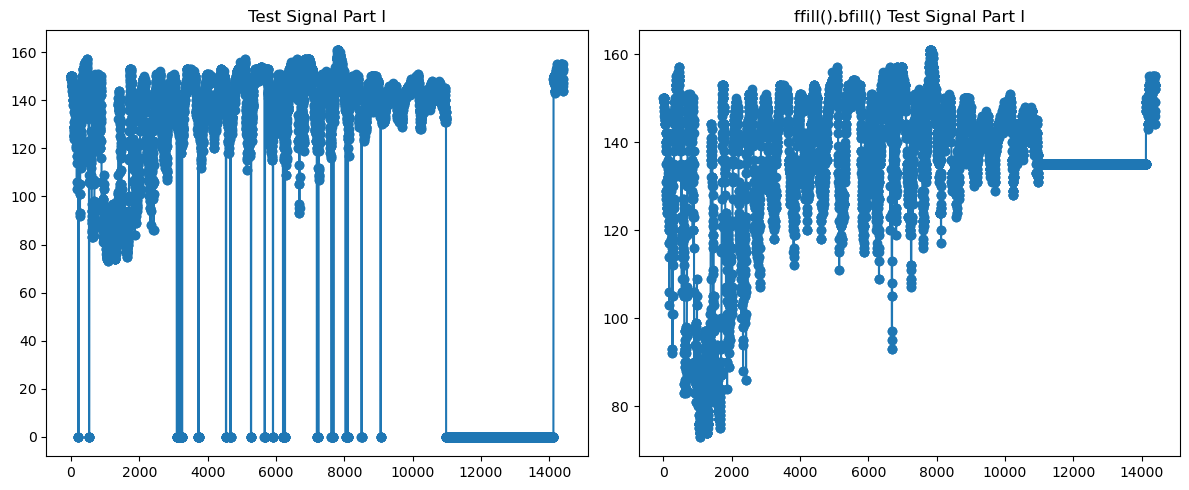

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(tes_sig_I, label='Test Signal Part I', marker='o')
plt.title('Test Signal Part I')

plt.subplot(1, 2, 2)
plt.plot(tes_sig_I_interp, label='ffill().bfill() Test Signal Part I', marker='o')
plt.title('ffill().bfill() Test Signal Part I')
plt.tight_layout()
plt.show()

Zeros are transformed into nan in order to be considered "missing" values. Using forward fill "ffill()", the missing values are replaced with the most recent non-missing values before them. Using backward fill "bill()", the missing values are replaced with the most recent non-missing values after them. One pass of each is required to ensure all values that must be filled are filled and no nan values remain in the series.

#### Example of how part II is interpolated/filled 

In [32]:
test_sig_II = allDataDf.FHR_st_II.iloc[100]

In [33]:
test_sig_II_interp = np.array(pd.Series(test_sig_II).replace(0.0, np.nan).ffill().bfill())

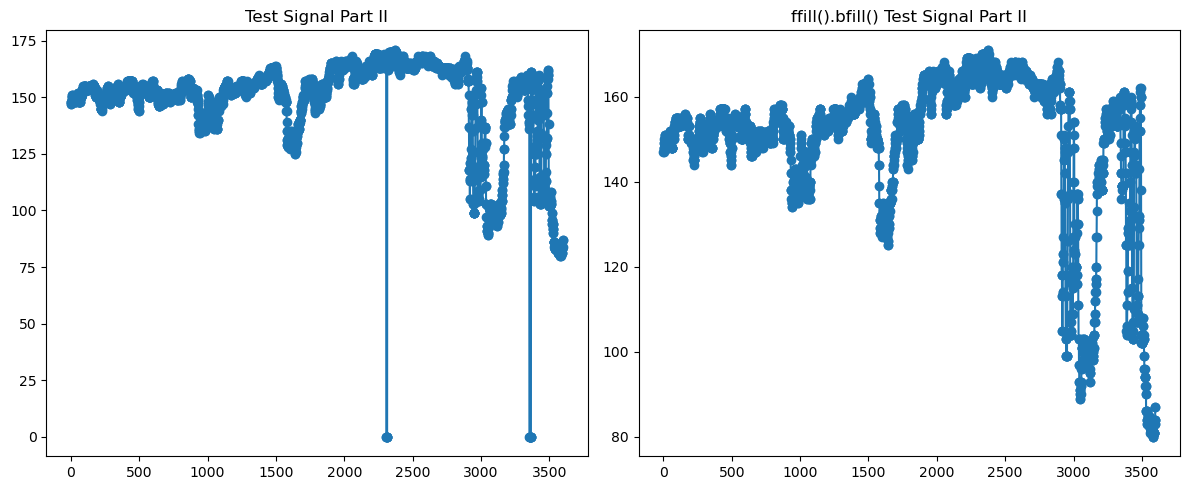

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(test_sig_II, label='Test Signal Part II', marker='o')
plt.title('Test Signal Part II')

plt.subplot(1, 2, 2)
plt.plot(test_sig_II_interp, label='ffill().bfill() Test Signal Part II', marker='o')
plt.title('ffill().bfill() Test Signal Part II')
plt.tight_layout()
plt.show()

Applying the same method as before, we get similarly good results.

In [35]:
allDataDf['FHR_st_I_ffill']= [None]*len(allDataDf)
allDataDf['FHR_st_II_ffill']= [None]*len(allDataDf)

#before being filled forward, zeros must be turned into nan
allDataDf['FHR_st_I_ffill']= allDataDf.FHR_st_I.apply(lambda x: np.array(pd.Series(x).replace(0.0, np.nan).ffill().bfill()))
I_nan_detection = allDataDf['FHR_st_I_ffill'].apply(lambda x: np.isnan(x).any())
allDataDf['FHR_st_II_ffill']= allDataDf.FHR_st_II.apply(lambda x: np.array(pd.Series(x).replace(0.0, np.nan).ffill().bfill()))
II_nan_detection = allDataDf['FHR_st_II_ffill'].apply(lambda x: np.isnan(x).any())

A check for any possible NaN values is implemented and any entries with NaN values are deleted.

In [36]:
I_nan_idx = []
for i in range(0,len(allDataDf)):
    if I_nan_detection.iloc[i] == True:
        I_nan_idx.append(i)
    
II_nan_idx = []
for i in range(0,len(allDataDf)):
    if II_nan_detection.iloc[i] == True:
        II_nan_idx.append(i)
        
print("NaN count in part I signals: ",I_nan_idx)
print("NaN count in part II signals: ",II_nan_idx)

NaN count in part I signals:  []
NaN count in part II signals:  [128]


In [37]:
allDataDf.drop(II_nan_idx, inplace=True)
allDataDf = allDataDf.reset_index(drop=True)
allDataDf.index

RangeIndex(start=0, stop=227, step=1)

## FHR Feature Extraction 

<br>Specific feautures must be extracted from the FHR signal. The FHR signal contains heart rate variability (HRV) information. There are several types of methods that help extract features from the signal and they include time domain methods, frequency domain methods, geometric methods, time-frequency methods and non-linear methods. The features that will be extracted correspond to the frequency domain, time domain, time-frequency domain and some entropy based non-linear methods.</br>
<br><b>Time Domain Features:</b> mean and median NN intervals (mean_nni, median_nni), SDNN, RMSSD, NNI20, PNNI20</br>
<br><b>Frequency Domain Features:</b> LF/HF Ratio, Total Power, VLF </br>
<br><b>Time-Frequency Features:</b> Haar Wavelet St. Deviation, Mean and Shannon Entropy</br>
<br><b>Entropy Features:</b> Sample Entropy, Bubble Entropy and Shannon Entropy </br>

#### Finding the Haar Wavelet optimal scale parameter for the Haar features 

The Haar wavelet is applied with multiple scale settings. The goal is to choose the scale that provides a min median case for all signals in each stage and then extract more information from the detail coefficient vector of that scale. 

In [38]:
def haar_det_coeff_std_calc(signal,scale):
    det_coeff_stdevs = []
    for i in range(1,scale+1):
        coeffs = pywt.wavedec(signal, 'haar', level=i)
        det_coeff_stdevs.append(np.std(coeffs[1]))
    #print(det_coeff_stdevs)
    min_pos = np.argmin(det_coeff_stdevs)
    return [det_coeff_stdevs[min_pos],min_pos+1] #returns[min stdev ,min position + 1 = min scale]

In [39]:
allDataDf['haar_I_min']= [None]*len(allDataDf)
allDataDf['haar_I_min'] = allDataDf['FHR_st_I_ffill'].apply(lambda x: haar_det_coeff_std_calc(x,10))
optimal_scale_I = np.median(allDataDf['haar_I_min'].apply(lambda x: x[1]))
print("Optimal Haar Scale (I): ",optimal_scale_I)

Optimal Haar Scale (I):  1.0


In [40]:
allDataDf['haar_II_min']= [None]*len(allDataDf)
allDataDf['haar_II_min'] = allDataDf['FHR_st_II_ffill'].apply(lambda x: haar_det_coeff_std_calc(x,10))
optimal_scale_II = np.median(allDataDf['haar_II_min'].apply(lambda x: x[1]))
print("Optimal Haar Scale (II): ",optimal_scale_II)

Optimal Haar Scale (II):  1.0


#### Set features 

In [41]:
#initialize columns 

#init time feature columns for stage I
allDataDf['FHR_I_ffill_mean_nni']= [None]*len(allDataDf)
allDataDf['FHR_I_ffill_median_nni']= [None]*len(allDataDf)
allDataDf['FHR_I_ffill_sdnn']= [None]*len(allDataDf)
allDataDf['FHR_I_ffill_rmssd']= [None]*len(allDataDf) 
allDataDf['FHR_I_ffill_nni20']= [None]*len(allDataDf) 
allDataDf['FHR_I_ffill_pnni20']= [None]*len(allDataDf) 

#init freq feature columns for stage I
allDataDf['FHR_I_ffill_lf_hf_ratio']= [None]*len(allDataDf) 
allDataDf['FHR_I_ffill_total_power']= [None]*len(allDataDf) 
allDataDf['FHR_I_ffill_vlf']= [None]*len(allDataDf)

#init Haar Wavelet feature columns for stage I
allDataDf['FHR_I_ffill_haar_stdev']= [None]*len(allDataDf) 
allDataDf['FHR_I_ffill_haar_mean']= [None]*len(allDataDf) 
allDataDf['FHR_I_ffill_haar_shan_entr']= [None]*len(allDataDf) 

#init Entropy  feature columns for stage I
allDataDf['FHR_I_ffill_samp_entr']= [None]*len(allDataDf) 
allDataDf['FHR_I_ffill_bub_entr']= [None]*len(allDataDf) 
allDataDf['FHR_I_ffill_shan_entr']= [None]*len(allDataDf) 


#init time feature columns for stage II
allDataDf['FHR_II_ffill_mean_nni']= [None]*len(allDataDf)
allDataDf['FHR_II_ffill_median_nni']= [None]*len(allDataDf)
allDataDf['FHR_II_ffill_sdnn']= [None]*len(allDataDf)
allDataDf['FHR_II_ffill_rmssd']= [None]*len(allDataDf) 
allDataDf['FHR_II_ffill_nni20']= [None]*len(allDataDf) 
allDataDf['FHR_II_ffill_pnni20']= [None]*len(allDataDf) 

#init freq feature columns for stage I
allDataDf['FHR_II_ffill_lf_hf_ratio']= [None]*len(allDataDf) 
allDataDf['FHR_II_ffill_total_power']= [None]*len(allDataDf) 
allDataDf['FHR_II_ffill_vlf']= [None]*len(allDataDf)
#init Haar Wavelet feature columns for stage II
allDataDf['FHR_II_ffill_haar_stdev']= [None]*len(allDataDf) 
allDataDf['FHR_II_ffill_haar_mean']= [None]*len(allDataDf) 
allDataDf['FHR_II_ffill_haar_shan_entr']= [None]*len(allDataDf) 

#init Entropy  feature columns for stage II
allDataDf['FHR_II_ffill_samp_entr']= [None]*len(allDataDf) 
allDataDf['FHR_II_ffill_bub_entr']= [None]*len(allDataDf) 
allDataDf['FHR_II_ffill_shan_entr']= [None]*len(allDataDf) 


In [42]:
#set time and frequency features for stages I and II
for i in range(0,len(allDataDf)):
    #print("--- --- ---")
    #print(i)
    stage_I = allDataDf.FHR_st_I_ffill.iloc[i]
    stage_II = allDataDf.FHR_st_II_ffill.iloc[i]
    time_feats_I = get_time_domain_features(stage_I)
    time_feats_II = get_time_domain_features(stage_II)
    freq_feats_I = get_frequency_domain_features(stage_I)
    freq_feats_II = get_frequency_domain_features(stage_II)
    
    #STAGE I
    
    #time feature columns for stage I
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_mean_nni')] = time_feats_I['mean_nni']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_median_nni')] = time_feats_I['median_nni']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_sdnn')] = time_feats_I['sdnn']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_rmssd')] = time_feats_I['rmssd']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_nni20')] = time_feats_I['nni_20']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_pnni20')] = time_feats_I['pnni_20']

    #freq feature columns for stage I
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_lf_hf_ratio')] = freq_feats_I['lf_hf_ratio']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_total_power')] = freq_feats_I['total_power']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_vlf')] = freq_feats_I['vlf']


    
    #STAGE II
    
    #time feature columns for stage II
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_mean_nni')] = time_feats_II['mean_nni']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_median_nni')] = time_feats_II['median_nni']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_sdnn')] = time_feats_II['sdnn']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_rmssd')] = time_feats_II['rmssd']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_nni20')] = time_feats_II['nni_20']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_pnni20')] = time_feats_II['pnni_20']

    #freq feature columns for stage II
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_lf_hf_ratio')] = freq_feats_II['lf_hf_ratio']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_total_power')] = freq_feats_II['total_power']
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_vlf')] = freq_feats_II['vlf']
    

In [43]:
#haar and entropy features for stage I and II
for i in range(0,len(allDataDf)):
    stage_I = allDataDf.FHR_st_I_ffill.iloc[i]

    #Haar Wavelet feature columns for stage I
    coeffs_I = pywt.wavedec(stage_I, 'haar', level=int(optimal_scale_I))
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_haar_stdev')] = np.std(coeffs_I[1])
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_haar_mean')] = np.mean(coeffs_I[1])
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_haar_shan_entr')] = scipy.stats.entropy(coeffs_I[1])

    #Entropy  feature columns for stage I
    Bubb_I, H_I = EH.BubbEn(stage_I)
    Samp_I, A_I, B_I = EH.SampEn(stage_I,m=3)
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_samp_entr')] = Samp_I[3]
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_bub_entr')] = Bubb_I[0]
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_I_ffill_shan_entr')] = scipy.stats.entropy(stage_I)
    
    
    stage_II = allDataDf.FHR_st_II_ffill.iloc[i]

    #Haar Wavelet feature columns for stage II
    coeffs_II = pywt.wavedec(stage_II, 'haar', level=int(optimal_scale_II))
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_haar_stdev')] = np.std(coeffs_II[1])
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_haar_mean')] = np.mean(coeffs_II[1])
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_haar_shan_entr')] = scipy.stats.entropy(coeffs_II[1])

    #Entropy  feature columns for stage II
    Bubb_II, H_II = EH.BubbEn(stage_II)
    Samp_II, A_II, B_II = EH.SampEn(stage_II,m=3)
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_samp_entr')] = Samp_II[3]
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_bub_entr')] = Bubb_II[0]
    allDataDf.iloc[i, allDataDf.columns.get_loc('FHR_II_ffill_shan_entr')] = scipy.stats.entropy(stage_II)

In [44]:
#allDataDf.info()

In [45]:
np.unique(allDataDf['FHR_I_ffill_haar_shan_entr'])

array([-inf], dtype=object)

In [46]:
np.unique(allDataDf['FHR_I_ffill_haar_shan_entr'])

array([-inf], dtype=object)

In [47]:
np.unique(allDataDf['FHR_II_ffill_haar_shan_entr'])

array([-inf], dtype=object)

The shannon entropy columns must be excluded since they do not provide any information other than -inf being set to all entries.

### Stage I - Stage II Difference Features 

Experimentally, a few features that measure differences between the two stages will be computed to see if they contribute to better classification or not. Such features are going to be the absolute difference of <b>nni20</b>, <b>LF/HF</b> and of the <b>Haar Wavelet St.Dev</b>. 

In [48]:
#init Haar Wavelet feature columns for stage I
allDataDf['diff_nni20']= allDataDf['FHR_I_ffill_nni20'] - allDataDf['FHR_II_ffill_nni20']
allDataDf['diff_nni20'] = allDataDf['diff_nni20'].apply(lambda x : np.abs(x))
allDataDf['diff_lf_hf']= allDataDf['FHR_I_ffill_lf_hf_ratio'] - allDataDf['FHR_II_ffill_lf_hf_ratio'] 
allDataDf['diff_lf_hf'] = allDataDf['diff_lf_hf'].apply(lambda x : np.abs(x))
allDataDf['diff_haar_std']= allDataDf['FHR_I_ffill_haar_stdev']-allDataDf['FHR_II_ffill_haar_stdev']
allDataDf['diff_haar_std'] = allDataDf['diff_haar_std'].apply(lambda x : np.abs(x))
#'diff_nni20',
#'diff_lf_hf',
#'diff_haar_std',


### Create main dataframe that holds the features and data to be used as input in classifiers 

Before moving on to classification implementations, it is important to isolate the necessary columns and create a new dataframe which will be used for classification purposes.

In [49]:
to_keep = ['pH',
'BDecf',
'pCO2',
'BE',
'Apgar1',
'Apgar5',
'Gest.weeks',
'Weight(g)',
'Sex',
'Age',
'Gravidity',
'Parity',
'Diabetes',
'Hypertension',
'Preeclampsia',
'Liq.praecox',
'Pyrexia',
'Meconium',
'Presentation',
'Induced',
'NoProgress',
'CK/KP',
'dbID',
'Rec.type',
'FHR_I_ffill_mean_nni',
'FHR_I_ffill_median_nni',
'FHR_I_ffill_sdnn',
'FHR_I_ffill_rmssd',
'FHR_I_ffill_nni20',
'FHR_I_ffill_pnni20',
'FHR_I_ffill_lf_hf_ratio',
'FHR_I_ffill_total_power',
'FHR_I_ffill_vlf',
'FHR_I_ffill_haar_stdev',
'FHR_I_ffill_haar_mean',
#'FHR_I_ffill_haar_shan_entr',
'FHR_I_ffill_samp_entr',
'FHR_I_ffill_bub_entr',
#'FHR_I_ffill_shan_entr',
'FHR_II_ffill_mean_nni',
'FHR_II_ffill_median_nni',
'FHR_II_ffill_sdnn',
'FHR_II_ffill_rmssd',
'FHR_II_ffill_nni20',
'FHR_II_ffill_pnni20',
'FHR_II_ffill_lf_hf_ratio',
'FHR_II_ffill_total_power',
'FHR_II_ffill_vlf',
'FHR_II_ffill_haar_stdev',
'FHR_II_ffill_haar_mean',
#'FHR_II_ffill_haar_shan_entr',
'FHR_II_ffill_samp_entr',
'FHR_II_ffill_bub_entr',
#'FHR_II_ffill_shan_entr',
'diff_nni20',
'diff_lf_hf',
'diff_haar_std']

In [50]:
mainDf = allDataDf[to_keep].copy()
mainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pH                        227 non-null    float64
 1   BDecf                     222 non-null    float64
 2   pCO2                      222 non-null    float64
 3   BE                        222 non-null    float64
 4   Apgar1                    227 non-null    float64
 5   Apgar5                    227 non-null    float64
 6   Gest.weeks                227 non-null    float64
 7   Weight(g)                 227 non-null    float64
 8   Sex                       227 non-null    float64
 9   Age                       227 non-null    float64
 10  Gravidity                 226 non-null    float64
 11  Parity                    227 non-null    float64
 12  Diabetes                  227 non-null    float64
 13  Hypertension              227 non-null    float64
 14  Preeclamps

The 'BDecf', 'pCO2', 'BE' columns contain a few null values. The corresponding entries can be removed.      

In [51]:
BDecf_nan_detection = mainDf['BDecf'].apply(lambda x: np.isnan(x).any())
BDecf_nan_idx = []
for i in range(0,len(mainDf)):
    if BDecf_nan_detection.iloc[i] == True:
        BDecf_nan_idx.append(i)
print(BDecf_nan_idx)

[19, 32, 98, 160, 178]


In [52]:
pCO2_nan_detection = mainDf['pCO2'].apply(lambda x: np.isnan(x).any())
pCO2_nan_idx = []
for i in range(0,len(mainDf)):
    if pCO2_nan_detection.iloc[i] == True:
        pCO2_nan_idx.append(i)
print(pCO2_nan_idx)

[19, 32, 98, 160, 178]


In [53]:
BE_nan_detection = mainDf['BE'].apply(lambda x: np.isnan(x).any())
BE_nan_idx = []
for i in range(0,len(mainDf)):
    if BE_nan_detection.iloc[i] == True:
        BE_nan_idx.append(i)
print(BE_nan_idx)

[19, 32, 98, 160, 178]


In [54]:
mainDf.drop(BDecf_nan_idx, inplace=True)
mainDf = mainDf.reset_index(drop=True)
mainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pH                        222 non-null    float64
 1   BDecf                     222 non-null    float64
 2   pCO2                      222 non-null    float64
 3   BE                        222 non-null    float64
 4   Apgar1                    222 non-null    float64
 5   Apgar5                    222 non-null    float64
 6   Gest.weeks                222 non-null    float64
 7   Weight(g)                 222 non-null    float64
 8   Sex                       222 non-null    float64
 9   Age                       222 non-null    float64
 10  Gravidity                 221 non-null    float64
 11  Parity                    222 non-null    float64
 12  Diabetes                  222 non-null    float64
 13  Hypertension              222 non-null    float64
 14  Preeclamps

In [55]:
mainDf.to_csv('C:/Users/Nefeli/Desktop/biomed_project_data/mainDf_int.csv',index=False)